<h1>Exploring Cryptocurrency with Python (work in progress)</h1>

This project will look at cryptocurrency from a data-driven approach. Most code will be written in python to utilize dataframes and the analysis capabilities it brings. Much of our data will be pulled from the Binance API https://github.com/binance-exchange. Binance is one of the leading cryptocurrency exchanges and provides access to useful information for all of their cryptocurrencies listed. Information such as Open time, daily highs, daily lows, volume, opening and closing prices, much of the information we need to do analysis can be pulled from the Binance API. 

Binance has a python wrapper that we can utilize to pull data we need https://github.com/binance-exchange/python-binance.

<h3>Step 0.1 - Import The Dependencies</h3>
<p>
Let's start by importing required dependencies.
</p>

In [1]:
import time
#import dateparser
#import pytz
from pytz import UTC
from pytz import timezone
import json

from datetime import datetime

from binance.client import Client
client = Client("", "")

In [2]:
import numpy as np
import pandas as pd
import pickle

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns
#import math
from pandas.plotting import scatter_matrix


<h1>Step 1 - Retrieve Cryptocurrency Data from Binance</h1>

<h3>step 1.1 - Write Function to Download/Load Currency Data</h3>
<p>
Next we will write a helper function that downloads and caches individual ticker information from the Binance API. The function first tries to load a dataframe from a cached file, if the file does not exist it downloads real time data from the Binance API and caches it to a file for next time. 
</p>


In [4]:

def get_symbol_df(symbol, time_interval, start_time, end_time = None):
    '''Download and cache Binance data for given symbol pair like ETHBTC'''
    
    cache_path = '{} {} {}.pkl'.format(symbol, time_interval, start_time)
    try:
        f = open(cache_path, 'rb')
        data_df = pickle.load(f)
        #print('Loaded {} from cache'.format(symbol))
        
    except(OSError, IOError) as e:
        print('Downloading {} from Binance'.format(symbol))
    
        #get symbol data from binance 
        candles = client.get_historical_klines(symbol, time_interval, start_time, end_time)
    
        #labels for dataframe
        labels = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades',
         'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

        #populate database with symbols info
        data_df = pd.DataFrame(candles, columns=labels)
    
       
        #convert timestamp 
        data_df['Open time'] = pd.to_datetime(data_df['Open time'].div(1000), unit='s')
        data_df['Close time'] = pd.to_datetime(data_df['Close time'].div(1000), unit='s')
        
        data_df.to_pickle(cache_path)
        print('Cached {} at {}'.format(symbol, cache_path))
    
    return data_df
 


<h3>Step 1.2 - Write Function to Prepare a List of Ticker Pairs</h3>
<p>
This function downloads and returns currently listed pairs of currencies from Bianance. We pass it one of the mainstream coins such as 'BTC' or 'ETH' to get a list of all symbol pairs associated with the base ticker.
</p>

In [5]:
def get_all_symbol_pairs(base):
    '''Returns list of symbol pairs for given base
    (would be easy to edit the code to add the most up to date price also)'''
    
    #get live ticker pairs currently listed on binance
    prices = client.get_all_tickers()
    
    symbol_list = []
    for d in prices:
        
        #if trailing 3 characters == base_symbol add the symbol pair and return list
        if(d['symbol'][-3:] == base):
            symbol_list.append(d['symbol'])
            
    return symbol_list

<h3>Step 1.3 - Get a Dictionary of Specified Ticker Pairs</h3>
<p>
Here we use the 2 functions from above to create and return a dictionary of ticker pairs as the keys, and the ticker dataframe as the values. The function takes the base ticker symbol (i.e. 'BTC'), time_interval like Client.KLINE_INTERVAL_4HOUR, start_time like '2017-01-01' and other optional parameters.
</p>

In [6]:
def get_all_symbol_df(base_symbol, time_interval, start_time ='2017-01-01', end_time = '2018-04-30', add_usd = True, cap = 10):
    '''Returns dictionary of dataframes of symbol pairs'''
    
    #use following line to get an updated list
    symbol_pairs = get_all_symbol_pairs(base_symbol)
    #symbol_pairs = btc_pairs
    
    dict_df = {}
    #get a dataframe of all symbol_pairs populated into a list
    for symbol in symbol_pairs:

        data_df = get_symbol_df(symbol, time_interval, start_time)
        data_df['ticker'] = symbol
       
        #add usd column
        if(add_usd):
            #this runs multi times when it doesn't need to....fix it later
            data_df = get_usd_price(data_df, time_interval)
        
        data_df = data_df.set_index('Open time')
        dict_df[symbol]  = data_df
        
        #####cap data amount for testing purposes. remove later 
        if(len(dict_df) >= cap):
            print('Loaded {} {} pairs'.format(cap, base_symbol))
            return dict_df
     
    print('Loaded {} {} pairs'.format(cap, base_symbol))
    return dict_df

<h3>Step 1.4 - Write Function to Pull USD Price for Coin</h3>
<p>
Finally, this helper function merges the USDT price of to the currency dataframe. USDT stands for USD tether, which is a cryptocurrency that closely tethers USD. We must be mindful that USDT does not perfectly tether USD and therefore is not the perfect representation of USD. However, for the purpose of this project it mirrors USD close enough that we will treat it as USD. 
</p>

In [7]:
#BTCUSDT only starts from 2017-08-17 for binance so we lose a month of data, 
#also USDT is not USD. Although it is tethered to USD it deviates depending on supply/demand
#we could pull true USD/BTC rates from other exchanges, but for our MVP this should be fine

def get_usd_price(df, interval):
    '''return df with usdt price added as column'''
    
    btc_usdt = get_symbol_df('BTCUSDT', interval, '2017-01-01')
    btc_usdt = btc_usdt.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close time', 
                                      'Quote asset volume','Number of trades', 
                                      'Taker buy base asset volume', 
                                      'Taker buy quote asset volume','Ignore'])
    
    #use inner here since usdt data starts on 2018-08-17 and was pulled more recently
    df =df.merge(btc_usdt, left_on='Open time', right_on = 'Open time', how='inner')
    
    df['Usd'] = round(df['Close_x'].astype(float) * df['Close_y'].astype(float), 2)
    df = df.drop(columns ='Close_y')
    df = df.rename(columns={"Close_x": "Close"})
    
    return df

<h3>Step 1.5 - Downloading Real Data from Binance</h3>
<p>
With our helper functions setup we can now start downloading BTC pair information. We will start with 4 hour intervals to see if anything interesting happens during this time frame. We can also get daily, 12hour, 1hour, 5min and even 1min intervals but 4hours seems like a good starting point. There are currently 121 BTC pair coins on Binance, but we will start with 21 first and expand the number of pairs later.
</p>

In [8]:
#dictionary of all BTC pairs in 4 hour intervals
#key = ticker pair , values = df 
btc_4hour_dict = get_all_symbol_df('BTC', Client.KLINE_INTERVAL_4HOUR, "2017-01-01", None, True, 21)

Loaded 21 BTC pairs


<h3>Step 1.6 - Explore Data</h3>
<p>
Here we will Explore our data with Basic dictionary and pandas commands.
</p>

In [9]:
btc_4hour_dict.keys()

dict_keys(['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'BCCBTC', 'GASBTC', 'HSRBTC', 'MCOBTC', 'WTCBTC', 'LRCBTC', 'QTUMBTC', 'YOYOBTC', 'OMGBTC', 'ZRXBTC', 'STRATBTC', 'SNGLSBTC', 'BQXBTC', 'KNCBTC', 'FUNBTC', 'SNMBTC', 'IOTABTC'])

Great, the dictionary contains BTC symbol pairs as the keys and dataframes as values. Now that our dictionary is loaded with dataframes, let's try accessing and exploring one of them. We will start with 'ETHBTC' since these currencies have the largest market capitalization and are also the most commonly known.

In [10]:
btc_4hour_dict['ETHBTC'].shape

(1490, 13)

In [11]:
btc_4hour_dict['ETHBTC'].head()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,ticker,Usd
Open time,,,,,,,,,,,,,
2017-08-17 04:00:00,0.07058200,0.07158200,0.06986700,0.07109400,4021.53900000,2017-08-17 07:59:59.999,283.55430669,3117,1950.58800000,137.64451024,46884.54339102,ETHBTC,309.26
2017-08-17 08:00:00,0.07088100,0.07122900,0.06883000,0.06940600,3403.20800000,2017-08-17 11:59:59.999,238.55234849,2984,1552.15500000,108.75034780,46866.63079951,ETHBTC,307.28
2017-08-17 12:00:00,0.06940600,0.07130400,0.06807700,0.07056100,5091.01200000,2017-08-17 15:59:59.999,353.53825545,4190,2497.76000000,173.62711426,47528.18909052,ETHBTC,307.11
2017-08-17 16:00:00,0.07023900,0.07225400,0.06959600,0.07012400,4916.10800000,2017-08-17 19:59:59.999,348.75722631,4351,2317.15100000,164.06176172,48886.75337014,ETHBTC,303.30
2017-08-17 20:00:00,0.07012400,0.07147500,0.06988900,0.07047900,3883.15300000,2017-08-17 23:59:59.999,273.59459740,4134,2017.00900000,142.12884692,50579.87228839,ETHBTC,302.01


In [12]:
btc_4hour_dict['ETHBTC'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1490 entries, 2017-08-17 04:00:00 to 2018-04-23 16:00:00
Data columns (total 13 columns):
Open                            1490 non-null object
High                            1490 non-null object
Low                             1490 non-null object
Close                           1490 non-null object
Volume                          1490 non-null object
Close time                      1490 non-null datetime64[ns]
Quote asset volume              1490 non-null object
Number of trades                1490 non-null int64
Taker buy base asset volume     1490 non-null object
Taker buy quote asset volume    1490 non-null object
Ignore                          1490 non-null object
ticker                          1490 non-null object
Usd                             1490 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory usage: 163.0+ KB


<h3>Step 1.7 - Clean up the DataFrame</h3>
<p>
Many of the dtypes are objects when they should be float. Let's convert those objects to float so we can run better analysis later on. We also want to set the ticker to category. The following function will help us with the conversion.
</p>

In [13]:
def clean_df_labels(df, pt=False):
    '''convert object dtypes to numeric, reset index'''
    
    df = df.apply(pd.to_numeric, errors='ignore')
    df['Close time'] = df['Close time'].astype('datetime64[ns]')
    
    #set index timezone info from UTC to US/Pacific
    df.index = df.index.tz_localize(UTC)
    if(pt):
        df.index = df.index.tz_convert('US/Pacific')
    
    #df.ticker = df.ticker.astype('category')
    
    return df

Now let's run the above function to clean up our dataframes. We will iterrate over each key value pair in our BTC dictionary.

In [14]:
for k, v in btc_4hour_dict.items():
    btc_4hour_dict[k] = clean_df_labels(btc_4hour_dict[k])

we can drop columns that we won't be using.

In [15]:
#drop unwanted columns
for k , v in btc_4hour_dict.items():
    btc_4hour_dict[k] = btc_4hour_dict[k].drop(columns = ['Close time', 'Quote asset volume',
                                             'Taker buy base asset volume', 'Taker buy quote asset volume','Ignore'])

Finally, For good measure, Let's view ETHBTC's info to check the conversion.

In [16]:
btc_4hour_dict['ETHBTC'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1490 entries, 2017-08-17 04:00:00+00:00 to 2018-04-23 16:00:00+00:00
Data columns (total 8 columns):
Open                1490 non-null float64
High                1490 non-null float64
Low                 1490 non-null float64
Close               1490 non-null float64
Volume              1490 non-null float64
Number of trades    1490 non-null int64
ticker              1490 non-null object
Usd                 1490 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 104.8+ KB


The dtypes look correct and we cleaned up the unneccesary columns by removing them. Let's also check the dataframe values to make sure everything is looking normal.

In [17]:
btc_4hour_dict['ETHBTC'].head()

,Open,High,Low,Close,Volume,Number of trades,ticker,Usd
Open time,,,,,,,,
2017-08-17 04:00:00+00:00,0.070582,0.071582,0.069867,0.071094,4021.539,3117,ETHBTC,309.26
2017-08-17 08:00:00+00:00,0.070881,0.071229,0.068830,0.069406,3403.208,2984,ETHBTC,307.28
2017-08-17 12:00:00+00:00,0.069406,0.071304,0.068077,0.070561,5091.012,4190,ETHBTC,307.11
2017-08-17 16:00:00+00:00,0.070239,0.072254,0.069596,0.070124,4916.108,4351,ETHBTC,303.30
2017-08-17 20:00:00+00:00,0.070124,0.071475,0.069889,0.070479,3883.153,4134,ETHBTC,302.01


<h1>Step 2 - Visual Exploratory Data Analysis</h1>

In this step we will be diving into our data to through visual EDA. There are many aspects that our best suited to be visually represented, especially in larger datasets like our own. Let's dive in and see what we can find.

<h3>Step 2.1 - Plot Cryptocurrencies</h3>
<p>
Here we will start by overlaying a plot of all our currency pairs. This is just to get a quick look at how the data looks side by side to see if anything stands out.
</p>

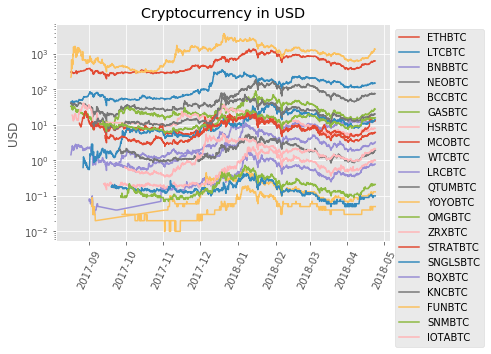

In [18]:
#Plot Cryptocurrency in USD
for k, v in btc_4hour_dict.items():
    
    plt.plot(v.index, v['Usd'], label = k)
    plt.yscale('log')
    plt.xticks(rotation='65')

plt.title('Cryptocurrency in USD')
plt.ylabel('USD')
plt.legend(bbox_to_anchor=(1, 1))    
plt.show()

Great we can visually see each coins movements, but the graph doesn't tell an amazing story of what is going on. Let's use a heatmap to visualize how currencies are related to one another.



<h3>Step 2.2 - Define Function to Merge Dataframes on Columns</h3>
<p>
First we will define a helper function that merges dataframe columns and returns a single dataframe with the merged columns. We will use this in the next step to isolate the USD columns from each dataframe and create a new dataframe.
</p>

In [19]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

<h3>Step 2.3 - Create New USD Price Dataframe</h3>
<p>
Now that the function is defined let's use it to merge all USD columns from each currency pair as a new dataframe.
</p>

In [20]:
#combine df consisting of each currency in USD
combined_df = merge_dfs_on_column(list(btc_4hour_dict.values()), 
                                        list(btc_4hour_dict.keys()), 'Usd' )

In [21]:
combined_df.tail()

,BCCBTC,BNBBTC,BQXBTC,ETHBTC,FUNBTC,GASBTC,HSRBTC,IOTABTC,KNCBTC,LRCBTC,...,MCOBTC,NEOBTC,OMGBTC,QTUMBTC,SNGLSBTC,SNMBTC,STRATBTC,WTCBTC,YOYOBTC,ZRXBTC
Open time,,,,,,,,,,,,,,,,,,,,,
2018-04-23 04:00:00+00:00,1403.96,13.07,3.09,641.13,0.05,28.85,8.03,2.09,1.80,0.78,...,13.16,77.80,15.70,20.66,0.1,0.21,5.97,13.73,0.13,1.02
2018-04-23 08:00:00+00:00,1396.96,13.73,3.09,636.83,0.05,27.96,8.13,2.18,1.88,0.78,...,13.34,76.96,15.57,20.48,0.1,0.21,6.20,13.69,0.13,1.03
2018-04-23 12:00:00+00:00,1397.88,13.46,3.11,645.82,0.05,28.12,8.10,2.10,1.89,0.79,...,12.95,76.22,15.50,20.26,0.1,0.21,6.05,13.84,0.13,1.01
2018-04-23 16:00:00+00:00,1362.66,13.46,3.14,639.46,0.05,27.82,8.00,2.08,1.92,0.79,...,13.00,75.90,15.64,20.29,0.1,0.21,6.06,13.99,0.13,0.99
2018-04-23 20:00:00+00:00,NaN,NaN,3.30,NaN,0.05,NaN,NaN,2.12,1.93,NaN,...,NaN,NaN,15.82,NaN,0.1,0.21,6.11,NaN,0.13,1.00


Looks good! now we can find the correlations between each pair 

<h3>Step 2.4 - Find Pearson Correlation Coefficient</h3>
<p>
Next, we will compute the correlation between each coin and print it out as a dataframe.
</p>

In [22]:
df_corr = combined_df.pct_change().corr(method='pearson')

In [23]:
df_corr

,BCCBTC,BNBBTC,BQXBTC,ETHBTC,FUNBTC,GASBTC,HSRBTC,IOTABTC,KNCBTC,LRCBTC,...,MCOBTC,NEOBTC,OMGBTC,QTUMBTC,SNGLSBTC,SNMBTC,STRATBTC,WTCBTC,YOYOBTC,ZRXBTC
BCCBTC,1.000000,0.235656,0.358264,0.287748,0.186690,0.221372,0.195861,0.394903,0.436226,0.145456,...,0.305752,0.255781,0.516982,0.507544,0.244762,0.318025,0.483626,0.329646,0.220255,0.407421
BNBBTC,0.235656,1.000000,0.414747,0.593719,0.247848,0.448117,0.488499,0.451921,0.488838,0.360413,...,0.457783,0.540779,0.584005,0.647529,0.308997,0.383169,0.549372,0.472898,0.388189,0.477055
BQXBTC,0.358264,0.414747,1.000000,0.553072,0.251137,0.446734,0.476486,0.466386,0.476561,0.341730,...,0.389432,0.512482,0.521906,0.481148,0.303804,0.445303,0.494179,0.445963,0.317182,0.440341
ETHBTC,0.287748,0.593719,0.553072,1.000000,0.293235,0.556509,0.532855,0.603995,0.656665,0.423792,...,0.550054,0.716772,0.766638,0.720572,0.408631,0.468333,0.682974,0.511231,0.404666,0.610494
FUNBTC,0.186690,0.247848,0.251137,0.293235,1.000000,0.225602,0.291805,0.268225,0.261729,0.154043,...,0.206416,0.262580,0.269104,0.264458,0.149095,0.196672,0.302657,0.243689,0.150151,0.269381
GASBTC,0.221372,0.448117,0.446734,0.556509,0.225602,1.000000,0.461720,0.499337,0.539287,0.346105,...,0.414727,0.743814,0.603892,0.541329,0.336113,0.390208,0.522029,0.358852,0.366694,0.422754
HSRBTC,0.195861,0.488499,0.476486,0.532855,0.291805,0.461720,1.000000,0.486844,0.542928,0.470131,...,0.395715,0.543900,0.595144,0.625191,0.370588,0.422448,0.591733,0.404076,0.392795,0.460539
IOTABTC,0.394903,0.451921,0.466386,0.603995,0.268225,0.499337,0.486844,1.000000,0.496567,0.294868,...,0.415639,0.543074,0.569305,0.527748,0.341237,0.428567,0.551666,0.477499,0.374056,0.434893
KNCBTC,0.436226,0.488838,0.476561,0.656665,0.261729,0.539287,0.542928,0.496567,1.000000,0.394548,...,0.431027,0.601801,0.625246,0.552614,0.423597,0.429470,0.598311,0.497921,0.343855,0.499829
LRCBTC,0.145456,0.360413,0.341730,0.423792,0.154043,0.346105,0.470131,0.294868,0.394548,1.000000,...,0.296643,0.388699,0.398547,0.353585,0.292875,0.317820,0.400455,0.283418,0.421689,0.346055


<h3>Step 2.5 - Visualizing with Heatmaps</h3>
<p>
We can see that cryptocurrencies are generally correlated. Let's try visualizing the Pearson Correlation Coefficients with a heatmap to help interpret our findings.
</p>

In [24]:
df_corr = combined_df.pct_change().corr(method='pearson')

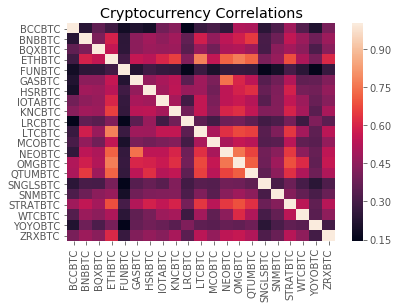

In [25]:
heatmap = sns.heatmap(df_corr)
plt.title('Cryptocurrency Correlations')
plt.show()

For the most part, the above heatmap signifies that there is indeed correlation between cryptocurrencies. Initially FUN and BCC stands out from the bunch since they are less correlated with all other currencies. I know BCC has stop trading for the most part from fradulent activity. For FUN coin I am not entirely sure why it has lower correlation, maybe we can dig deeper later.

Apart from several currencies, most currencies are correlated with one another. Let's see if there are any correlation differences from 2017 to 2018.

Here we willl isolate 2017 data from the combined dataframe and do the same for 2018

In [26]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
df_corr_2017 = combined_df_2017.pct_change().corr(method='pearson')

combined_df_2018 = combined_df[combined_df.index.year == 2018]
df_corr_2018 = combined_df_2018.pct_change().corr(method='pearson')

Let's plot the new 2017 dataframe as a heatmap. We will also filter the results to only show correlations higher than 0.5.

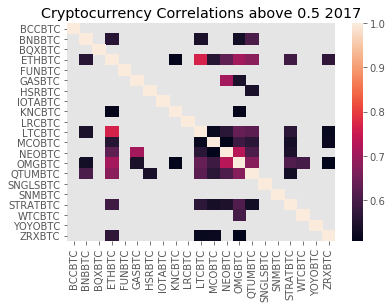

In [27]:
heatmap = sns.heatmap(df_corr_2017.where(df_corr_2017 >= .5))
plt.title('Cryptocurrency Correlations above 0.5 2017')
plt.show()

<p>The white spaces signify coin pairs with less than 0.5 correlation. We can see that some coins have 0.5 or higher correlation so there definitely are correlation trends between certain coins.
</p>
<p>
Let's do the same analysis but with the 2018 data.
</p>

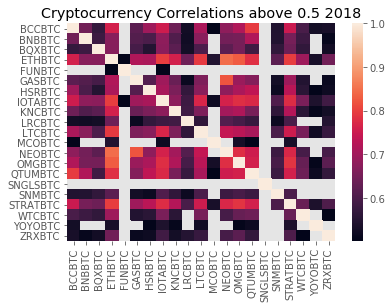

In [28]:
heatmap = sns.heatmap(df_corr_2018.where(df_corr_2018 >= .5))
plt.title('Cryptocurrency Correlations above 0.5 2018')
plt.show()

We can immediately see that 0.5 or higher correlations between cryptocurrencies has increased in numbers in 2018. 

<h3>Step 2.6 - Which Day of Week has The Highest Percentage Rise in Price?</h3>
<p>
Let's start by loading the time series for 1 day intervals, this way we can have access to 1 day closing data without further wrangling our 4hour dataset. we will use the get_all_symbol_df function from earlier to load a dictionary full of symbol pair dataframes.
</p>

In [29]:
btc_1day_dict = get_all_symbol_df('BTC', Client.KLINE_INTERVAL_1DAY, "2017-01-01", None, True, 121)
for k, v in btc_1day_dict.items():
    btc_1day_dict[k] = clean_df_labels(btc_1day_dict[k])

Loaded 121 BTC pairs


Now merge all currencies on the USD column to get the dollar amount for each time interval. 



In [30]:
combined_df = merge_dfs_on_column(list(btc_1day_dict.values()), 
                                        list(btc_1day_dict.keys()), 'Usd' )

Then add a weekday column to keep track of which day of the week the interval is on.

In [31]:
combined_df['weekday'] = combined_df.index.weekday

Now we will add a 'sum' column for the sum of each row. This column will simply consist of the sum of all closing prices for the time series. We will use this sum to compare which days out of the week have the highest/lowest cumulative prices and rank the days of week in order. 

Certain coins were not listed on Binance when they first opened the exchange so they have NaN value for early dates. Let's make sure they are not counted in our analysis.

In [32]:
combined_df['sum'] = combined_df.sum(axis=1, skipna=True)


In [33]:
combined_df.tail()

,ADABTC,ADXBTC,AEBTC,AIONBTC,AMBBTC,APPCBTC,ARKBTC,ARNBTC,ASTBTC,BATBTC,...,XMRBTC,XRPBTC,XVGBTC,XZCBTC,YOYOBTC,ZECBTC,ZILBTC,ZRXBTC,weekday,sum
Open time,,,,,,,,,,,,,,,,,,,,,
2018-04-17 00:00:00+00:00,0.24,0.74,1.73,2.94,0.38,0.45,2.58,1.20,0.44,0.27,...,194.69,0.65,0.07,32.68,0.10,221.53,0.06,0.83,1,2868.35
2018-04-18 00:00:00+00:00,0.26,0.87,1.87,3.10,0.44,0.50,2.92,1.32,0.48,0.37,...,229.22,0.71,0.06,37.78,0.11,248.81,0.07,0.92,2,3231.83
2018-04-19 00:00:00+00:00,0.27,0.89,2.00,3.28,0.46,0.52,3.04,1.41,0.51,0.38,...,238.07,0.78,0.07,40.57,0.11,264.22,0.07,0.91,3,3435.77
2018-04-20 00:00:00+00:00,0.30,0.91,2.07,3.35,0.55,0.53,3.14,1.48,0.51,0.41,...,271.42,0.92,0.07,41.76,0.13,282.59,0.08,0.99,4,3780.00
2018-04-21 00:00:00+00:00,0.28,1.51,1.98,3.71,0.48,0.52,3.06,1.62,0.48,0.41,...,253.78,0.86,0.07,41.34,0.12,267.98,0.09,0.91,5,3708.00


<h3>Step 2.7 - Finding Weekly Numerical Patterns</h3>
<p>
Before we plot anything, Let's have a quick look to see if there are any patterns in the sum price. Here we will Sum up all prices for the particular day of week to search for patterns.
</p>

In [34]:

weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    print("Sum of {}'s {}".format(
        weekday_list[i], round(sum(combined_df.loc[combined_df['weekday'] == i]['sum']), 2)))
    

Sum of Monday's 117792.81
Sum of Tuesday's 117955.19
Sum of Wednesday's 119876.32
Sum of Thursday's 117561.11
Sum of Friday's 120671.74
Sum of Saturday's 123089.46
Sum of Sunday's 118507.37


This is nice but it is a bit hard to conceptualize these big numbers. What we really want is the measurement of percentage change for each day of the week. Let's calculate it for each intervals sum and add a new column called percent_change.

In [35]:
#create new column percent_change based on sum / sum +1 - 1
combined_df['percent_change'] = combined_df['sum'] / combined_df['sum'].shift(1) - 1

Now we will add up all the percent changes for each day of the week and see if there is a similiar pattern to what we see above.

In [36]:
for i in range(7):
    print("The Average percentage price change on {}'s is {}%".format(
        weekday_list[i],round(np.nansum(combined_df.loc[combined_df['weekday'] == i]['percent_change']), 2)))

The Average percentage price change on Monday's is -0.18%
The Average percentage price change on Tuesday's is 0.53%
The Average percentage price change on Wednesday's is 0.4%
The Average percentage price change on Thursday's is -0.85%
The Average percentage price change on Friday's is 1.57%
The Average percentage price change on Saturday's is 1.07%
The Average percentage price change on Sunday's is -0.37%


<p>
We can see that the values are fairly close to one another. However there seems to be a pattern where there is a dip in price on Thursday and a subsequent rise Friday through Saturday. This could be attributed to variance but we can't be sure until we run some different analyses. Note these are all in UTC.
</p>
<p>Let's take a quick look at what are daily up and down percentages look like before we delve further.

<h3>Step 2.8 - Ploting Daily Percentage Change in Price</h3>
<p>
Here we will plot a histogram and time-series plot, both from the same daily percentage change data.
</p>

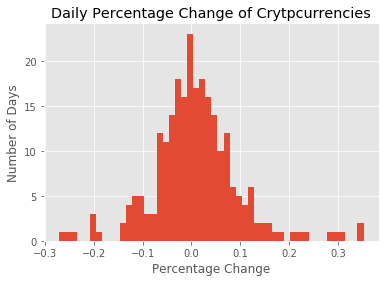

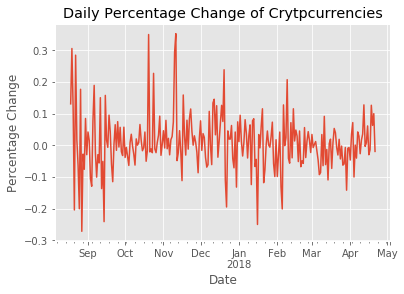

In [37]:
combined_df['percent_change'].hist(bins = 50)
plt.xlabel('Percentage Change')
plt.ylabel('Number of Days')
plt.title('Daily Percentage Change of Crytpcurrencies')
plt.show()

combined_df['percent_change'].plot()
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Daily Percentage Change of Crytpcurrencies')
plt.show()

<p>There are certain days with greater up/down swings but we can't really tell much from these graph. </p>

<p>
We will follow up by measuring which days of the week have the lowest and highest prices, for each week. This way we can see if Thursdays actually have more lows and Saturdays has more highs relative to the other days of the week.
<p>

<h3>Step 2.9 - Visualizing Price Trends by The Day of Week</h3>

<p>Here we will graph each day of week by how many positive/negative priced days they have. We will start by adding a column to keep track of positive change</p>

In [38]:
combined_df['Positive_change'] = combined_df['percent_change'] >= 0

Now let's group the df by weekday and Positive_change then print how many positive/negative days each weekday has.

In [39]:
pos_change = combined_df.groupby('weekday')['Positive_change']
pos_change.value_counts().sort_index(ascending = True)

weekday  Positive_change
0        False              20
         True               15
1        False              15
         True               20
2        False              17
         True               18
3        False              22
         True               14
4        False              11
         True               25
5        False              14
         True               22
6        False              19
         True               16
Name: Positive_change, dtype: int64

We can already see here that the trends we found earlier still hold. However, we can create a barchart to further visualize the data. Before that we will create two lists, pos_list and neg_list to store the count positive days and negative days for each weekday.

In [40]:
#create two lists for the count of positive/negative instances of price for each weekday
pos_list = []
neg_list = []
for name, group in pos_change:    
    pos_list.append(len(group.loc[group.values == True]))
    neg_list.append(len(group.loc[group.values == False]))

Finally, we can plot a bargraph using the 2 lists we created above.

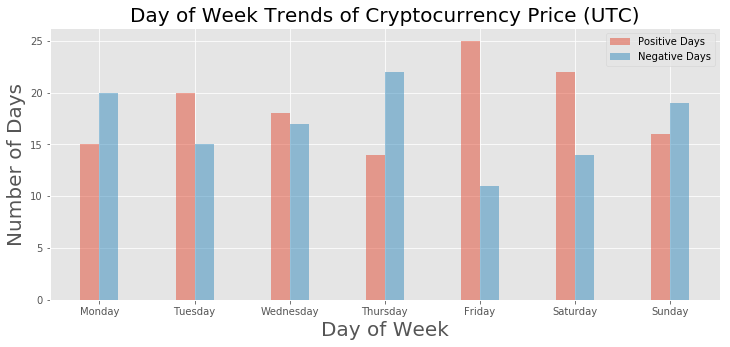

In [41]:
#string list of Monday through Sunday 
y_pos = np.arange(len(weekday_list))
width = 0.2

fig, ax = plt.subplots(figsize=(12,5))

#plot positive list
plt.bar(y_pos, pos_list, width, alpha = 0.5) 

#plot negative list
plt.bar(y_pos+width, neg_list, width, alpha=0.5) 

#set label, title and tickers
ax.set_ylabel('Number of Days', size = 20)
ax.set_xlabel('Day of Week', size = 20)
ax.set_title('Day of Week Trends of Cryptocurrency Price (UTC)', size = 20)
ax.set_xticks(y_pos + width/2)
ax.set_xticklabels(weekday_list)

plt.legend(['Positive Days', 'Negative Days'], loc='upper right')
plt.show()

<h3>Step 2.10 - Create a New Column for Pump & Dumps</h3>

<p>
The Pump & Dump(P&D) is an age old scheme that pumps the price of a cryptocurrency and once the price has peaked the organizers of the P&D sell the overpriced cryptocurrency onto less savvy buyers. Because of the new and unregulated nature of the current cryptocurrency markets, There are many of these P&D groups creating artificial spikes in the price at an alarming rate. We will keep track of these spikes in price and do further analysis on P&Ds later.
</p>
<p>
The definition of a P&D for our purposes will be, although simplistic, a 10% or larger spike in the value of a currency, followed by a similiar percentage drop within a 4 hour interval. This can be measured by (high/close - 1). We will calculate then add a P&D percentage to each row of the dataframe.
</p>

In [42]:
def add_pnd_column(df, percentage = 0):
    '''add pnd column by High - Close AND High - Open. filter by percentage'''
    df['Dip'] = round(df['High'].astype(float)/df['Close'].astype(float) - 1, 4)
    df['Pump'] = round(df['High'].astype(float)/df['Open'].astype(float) - 1, 4)
    df['PnD'] = round(df['High'].astype(float)/df['Close'].astype(float) - 1, 4)
    
    df = df.loc[(df['PnD'] >= percentage) & (df['Pump'] >= percentage)]
    
    return df

With our P&D helper function will iterate over each 4 hour time series dataframe, adding a pnd column for spikes larger than 10%

In [43]:
#add a pnd column for each df
pnd_4hour = {}
for k , v in btc_4hour_dict.items():
    pnd_4hour[k] = add_pnd_column(btc_4hour_dict[k], .1)

In [44]:
pnd_4hour['ETHBTC'].head()

,Open,High,Low,Close,Volume,Number of trades,ticker,Usd,Dip,Pump,PnD
Open time,,,,,,,,,,,
2017-12-08 04:00:00+00:00,0.025509,0.028665,0.024982,0.025806,30464.574,33090,ETHBTC,409.80,0.1108,0.1237,0.1108
2017-12-26 16:00:00+00:00,0.047207,0.053800,0.046430,0.047113,41546.696,50398,ETHBTC,743.81,0.1419,0.1397,0.1419


<h3>Step 2.11 - Calculate Frequency of Pump & Dumps</h3>
<p>
Here we will see how often 10% spikes or larger are happening for each BTC symbol pair, Getting a better idea of the frequency of these spike. We will caluculate the frequency by divinding the count of P&Ds by the total number of intervals for each given symbol.
</p>

In [45]:
pnd_frequency_dict = {}
for k , v in btc_4hour_dict.items():
    temp_pnd = round((pnd_4hour[k].PnD.count() / btc_4hour_dict[k].PnD.count()) *100, 2)
    pnd_frequency_dict[k] = temp_pnd
    print( 'Percentage of 10% or higher spikes for {} is {}%'.format(k, temp_pnd ))

Percentage of 10% or higher spikes for ETHBTC is 0.13%
Percentage of 10% or higher spikes for LTCBTC is 0.4%
Percentage of 10% or higher spikes for BNBBTC is 1.28%
Percentage of 10% or higher spikes for NEOBTC is 0.6%
Percentage of 10% or higher spikes for BCCBTC is 1.88%
Percentage of 10% or higher spikes for GASBTC is 2.95%
Percentage of 10% or higher spikes for HSRBTC is 2.8%
Percentage of 10% or higher spikes for MCOBTC is 2.35%
Percentage of 10% or higher spikes for WTCBTC is 3.57%
Percentage of 10% or higher spikes for LRCBTC is 4.19%
Percentage of 10% or higher spikes for QTUMBTC is 1.23%
Percentage of 10% or higher spikes for YOYOBTC is 4.75%
Percentage of 10% or higher spikes for OMGBTC is 1.05%
Percentage of 10% or higher spikes for ZRXBTC is 1.8%
Percentage of 10% or higher spikes for STRATBTC is 0.91%
Percentage of 10% or higher spikes for SNGLSBTC is 4.64%
Percentage of 10% or higher spikes for BQXBTC is 1.25%
Percentage of 10% or higher spikes for KNCBTC is 0.8%
Percentag

<h3>Step 2.12 - Graph Histogram of Pump & Dump Frequency</h3>
<p>
Now we are going to take the above information and graph it to get a more intuitive sense of the data.
</p>

In [46]:
#convert the above dictionary into a df
pnd_freq_df = pd.DataFrame.from_dict(pnd_frequency_dict, orient='index')
pnd_freq_df = pnd_freq_df.rename(index = str, columns = {0: "pnd_frequency"})

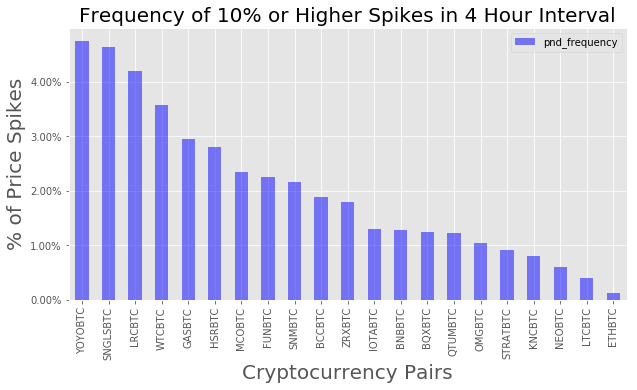

In [47]:
pnd_freq_df = pnd_freq_df.sort_values(by = ['pnd_frequency'], ascending = False)
pnd_freq_df.plot.bar(color = 'b', alpha = 0.5, figsize = (10, 5))

#plt.figure(figsize=(20,10))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel('% of Price Spikes', size = 20)
plt.xlabel('Cryptocurrency Pairs', size = 20)
plt.title('Frequency of 10% or Higher Spikes in 4 Hour Interval', size = 20)

plt.show()



Currencies with the highest percentage occurrence of Pump and Dumps have more than 4% occurrence, that is quite often. We also can see that currencies with higher market capitalization like ETH, LTC and NEO have less chance of Spikes. This is probably attributed to lower market capitalization coins being easier to manipulate because they have less money in them and needing less funds to orchestrate a P&D.

<h3>Step 2.13 - PnD to Volume Ratio Scatter Plot</h3>
volume to price trend scatter plot. Does high volume correlate with price going up or down?

<h1>Step 3 - Predicting Pump & Dumps with Machine Learning</h1>

<p>
In this section we will be applying machine learning to attempt to predict pump and dumps. 
We will start by applying basic k-Nearest Neighbors algorithm and see if it can successfully identify occurances of pump and dumps.
</p>
<p>
Here we will use a k-Nearest Neighbors from sklearn to see if we can identify pnds.
</p>

<h3>Step 3.1 - Preparing The Data</h3>
<p>Let's start by reloading our 4hour dictionary with all columns. We don't know initially which features will be useful in a predictive algorithm, so having more features will allow us to identify possible unforeseen pattern.
</p>

In [48]:
btc_1day_dict = get_all_symbol_df('BTC', Client.KLINE_INTERVAL_1DAY, "2017-01-01", None, True, 121)
for k, v in btc_1day_dict.items():
    btc_1day_dict[k] = clean_df_labels(btc_1day_dict[k])

Loaded 121 BTC pairs


We will define a helper function to add a Spike column with boolean values showing if there was a spike in price of 10% during the time series, add the pump and dump column and a percent_change column.

In [49]:
def add_columns_df(df , percentage =.1):
    
    for k , v in df.items():
        
        df[k] = add_pnd_column(df[k])

        df[k]['Spike'] = (df[k]['PnD'] >= percentage) & (df[k]['Pump'] >= percentage)

        #create new colum 'Weekday'
        #btc_4hour_dict[k]['Weekday'] = btc_4hour_dict[k].index.weekday

        #create new column 'percent_change' based on 'Close' / 'Open' - 1
        #df[k]['Percent_change'] = df[k]['Open'] / df[k]['Close'] - 1
    
    return df

In [50]:
btc_1day_dict = add_columns_df(btc_1day_dict)

<h3>Step 3.2 - Analyzing LRC-BTC Pair</h3>
<p>
We will begin our analysis by testing the LRCBTC currency pair. We choose LRC because in our initial findings of P&D frequency, LRCBTC was one of the highest among the group, so we will have plenty of P&D instances to give our algorithm. We will start by creating a Spike variable that contains a list of values from the 'Spike' column of our data frame.
</p>

In [51]:
#create new list from column 'Spike' 
spikes = btc_1day_dict['LRCBTC'].Spike.values

Next we will drop columns that do not contain numerical data from the data frame.

In [52]:
lrc_btc = btc_1day_dict['LRCBTC'].drop(
                        columns = ['ticker', 'Close time', 'Spike', 'PnD'])

In [53]:
lrc_btc.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,Usd,Dip,Pump
Open time,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,0.000020,0.000023,0.000014,0.000016,11830313.0,208.934242,2564,4235548.0,74.891924,6.080792e+07,0.08,0.4594,0.1500
2017-09-02 00:00:00+00:00,0.000016,0.000018,0.000011,0.000015,7904481.0,107.017647,1750,3122908.0,42.321466,6.545125e+07,0.07,0.2016,0.1154
2017-09-03 00:00:00+00:00,0.000015,0.000030,0.000013,0.000018,60384867.0,1154.837869,12960,24928356.0,479.836979,1.130648e+08,0.08,0.6216,1.0690
2017-09-04 00:00:00+00:00,0.000019,0.000019,0.000001,0.000008,50650980.0,583.319669,7251,17625508.0,200.079128,1.352150e+08,0.03,1.2941,0.0490
2017-09-05 00:00:00+00:00,0.000009,0.000011,0.000006,0.000009,34504925.0,292.853818,4810,14609458.0,126.353884,1.360266e+08,0.04,0.2419,0.2178


<h3>Step 3.3 - k-Nearest Neighbors</h3>
<p>In the realm of supervised machine learning, there are classification problems and regression problems. Since we are trying to predict if a P&D will happen, we have a classification problem. In classification problems we try to predict how our target variable will be categorized within known members of the category. In our P&D problem, our target variable categories are if a P&D will happpen or a P&D won't happen.
</p>
<p>The k-Nearest Neighbors(KNN) takes the nearest nodes and determines the categorization of new nodes depending on the given data</p>

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [55]:
def get_model_result(X, y, k, model_name = 'knn'):
    X_train,X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size = 0.3,
                                                        random_state = 21,
                                                        stratify = y)
    
    if(model_name is 'knn'):
        model = KNeighborsClassifier(n_neighbors = k)
    else:
        model = LogisticRegression()
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model.score(X_test, y_test)
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
    
    return X_train, X_test, y_train, y_test, model


In [56]:
X_train, X_test, y_train, y_test, model = get_model_result(lrc_btc, spikes, 1)

Confusion Matrix:
[[42  3]
 [ 5  5]]

             precision    recall  f1-score   support

      False       0.89      0.93      0.91        45
       True       0.62      0.50      0.56        10

avg / total       0.84      0.85      0.85        55



As we can see here our current does decent out of the box. When we set k to 1, our recall is at .64, which isn't bad. Let's try narrowing our features to the most relevant ones and see if our model does better.

<h3>Step 3.4 - Refine Feature Selection</h3>
<p>First we will import tools from sklearn to help with feature selection</p>

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

Here we will find the 5 best Features from our data frame and save them in variable X

In [58]:
X = SelectKBest(f_classif, k=5).fit_transform(lrc_btc, spikes)

In [59]:
lrc_btc.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,Usd,Dip,Pump
Open time,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,0.000020,0.000023,0.000014,0.000016,11830313.0,208.934242,2564,4235548.0,74.891924,6.080792e+07,0.08,0.4594,0.1500
2017-09-02 00:00:00+00:00,0.000016,0.000018,0.000011,0.000015,7904481.0,107.017647,1750,3122908.0,42.321466,6.545125e+07,0.07,0.2016,0.1154
2017-09-03 00:00:00+00:00,0.000015,0.000030,0.000013,0.000018,60384867.0,1154.837869,12960,24928356.0,479.836979,1.130648e+08,0.08,0.6216,1.0690
2017-09-04 00:00:00+00:00,0.000019,0.000019,0.000001,0.000008,50650980.0,583.319669,7251,17625508.0,200.079128,1.352150e+08,0.03,1.2941,0.0490
2017-09-05 00:00:00+00:00,0.000009,0.000011,0.000006,0.000009,34504925.0,292.853818,4810,14609458.0,126.353884,1.360266e+08,0.04,0.2419,0.2178


The top 5 features we get from SelectKBest are: Volume, Quote asset volume, Taker buy base asset volume, Dip and Pump. 

<h3>Step 3.5 - Model Complexity Curve for KNN</h3>
<p>Here we will setup a function to show a graph of which k value works best for knn, for the given train test values.
</p>

In [60]:
def get_model_comp_curve(X_train, y_train, X_test, y_test):
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 15)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors = k)

        # Fit the classifier to the training data
        knn.fit(X_train, y_train)

        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train)

        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)

    # Generate plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

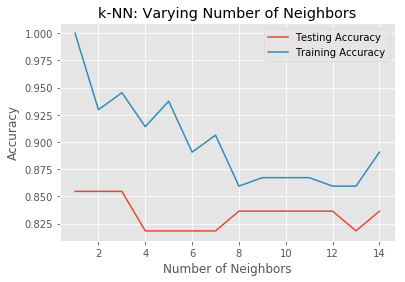

In [61]:
get_model_comp_curve(X_train, y_train, X_test, y_test)

<h3>Step 3.6 - Predicting Future Time Series of LRC</h3>
<p>
Up until now we have been using data to predict if a P&D happened during the same time series. Now we will apply what we have learned about the best features and the optimal knn variable to predict P&Ds in future time series.
</p>
<p>
First let's reset lrc_btc to include the 5 main features plus the PnD column. We are using PnD here because it could contribute to future time-series having more P&Ds.
</p>

In [62]:
lrc_btc = btc_1day_dict['LRCBTC'].drop(
                        columns = ['ticker', 'Close time', 'Spike','Open', 'High', 'Low', 'Close',
                                  'Number of trades', 'Ignore', 'Usd', 'Taker buy quote asset volume'])

In [63]:
lrc_btc.head()

,Volume,Quote asset volume,Taker buy base asset volume,Dip,Pump,PnD
Open time,,,,,,
2017-09-01 00:00:00+00:00,11830313.0,208.934242,4235548.0,0.4594,0.1500,0.4594
2017-09-02 00:00:00+00:00,7904481.0,107.017647,3122908.0,0.2016,0.1154,0.2016
2017-09-03 00:00:00+00:00,60384867.0,1154.837869,24928356.0,0.6216,1.0690,0.6216
2017-09-04 00:00:00+00:00,50650980.0,583.319669,17625508.0,1.2941,0.0490,1.2941
2017-09-05 00:00:00+00:00,34504925.0,292.853818,14609458.0,0.2419,0.2178,0.2419


<p>Now we will shift each column and add it to the data frame. shifting allows us to easily analyze current and next time-series side by side. Here we will define a helper function for shifting all columns of a data frame.
</p>

In [64]:
#helpter function that adds shifted columns to dataframe
def shift_df(df, shift_count):
    temp_df = pd.DataFrame()
    for i in range(1, shift_count + 1):
        for column in df:
            temp_df['{}_{}'.format(column, i)] = df[column].shift(i)
    
    temp_df.merge(df, left_index=True, right_index=True)
    return temp_df

Next with our new function, we will populate each row of our data frame with 12 hours of time-series data. This is to analyze if any patterns emerge in the 12 hours that we can use to predict a P&D in the next 4 hours.

In [65]:
lrc_btc = shift_df(lrc_btc, 3)
lrc_btc.head()

,Volume_1,Quote asset volume_1,Taker buy base asset volume_1,Dip_1,Pump_1,PnD_1,Volume_2,Quote asset volume_2,Taker buy base asset volume_2,Dip_2,Pump_2,PnD_2,Volume_3,Quote asset volume_3,Taker buy base asset volume_3,Dip_3,Pump_3,PnD_3
Open time,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-02 00:00:00+00:00,11830313.0,208.934242,4235548.0,0.4594,0.1500,0.4594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-03 00:00:00+00:00,7904481.0,107.017647,3122908.0,0.2016,0.1154,0.2016,11830313.0,208.934242,4235548.0,0.4594,0.1500,0.4594,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-04 00:00:00+00:00,60384867.0,1154.837869,24928356.0,0.6216,1.0690,0.6216,7904481.0,107.017647,3122908.0,0.2016,0.1154,0.2016,11830313.0,208.934242,4235548.0,0.4594,0.1500,0.4594
2017-09-05 00:00:00+00:00,50650980.0,583.319669,17625508.0,1.2941,0.0490,1.2941,60384867.0,1154.837869,24928356.0,0.6216,1.0690,0.6216,7904481.0,107.017647,3122908.0,0.2016,0.1154,0.2016


Now we will drop the first 3 rows from our lrc_btc data frame to compensate for the NaN values created from the shift. We will also remove the first 3 elements from spike to match the data frame.

In [66]:
#drop top 3 rows to exclude NaN values from lrc_btc
lrc_btc = lrc_btc.drop(lrc_btc.index[0:3])

#delete first 3 elements of Spikes to match data frame rows
spikes = btc_1day_dict['LRCBTC'].Spike.values
spikes = np.delete(spikes,[0,1,2])
print(lrc_btc.shape)
print(spikes.shape)

(180, 18)
(180,)


Now that our X and y values are prepared, we can test the results we get from a knn analysis. 

Confusion Matrix:
[[40  5]
 [ 7  2]]

             precision    recall  f1-score   support

      False       0.85      0.89      0.87        45
       True       0.29      0.22      0.25         9

avg / total       0.76      0.78      0.77        54



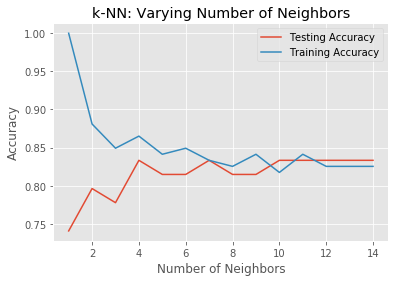

In [67]:
X_train, X_test, y_train, y_test, model = get_model_result(lrc_btc, spikes, 3)
get_model_comp_curve(X_train, y_train, X_test, y_test)

Out of the 9 P&Ds we are only able to predict 2 and we also have 5 false positives. This is a good start but we would hope to see better predictive results. One thing to note here is, our dataset is fairly small so our results are not conclusive. Using the datasets of other coins should provide refinement to the algorithm.

<h3>Step 3.7 - kNN Analysis on Other BTC Pairs</h3>
<p>
Here we will test our findings on the other BTC pairs we have to see if our KNN can predict P&Ds at a reasonable rate. First we will write a helper function to prepare each data frame that we did above.
</p>

In [68]:
# method prints out results for given model on all df in dict. can specify target var
def get_all_model(pair_dict, intervals = 3, model = 'knn', graph = False, target = 'Spike', knn_k = 5):
    #fix so we can use other targets besides 'Spike' we need True/False column for target built within this func
    
    for k, v in pair_dict.items():

        df = pair_dict[k]
        y = df[target].values
        df = df.drop(columns = ['ticker', 'Close time', 'Spike','Open', 'High', 'Low', 'Close',
                                'Taker buy quote asset volume', 'Ignore', 'Usd',
                                'Number of trades',
                                  'PnD'])

        #merge intervals time series together
        df = shift_df(df, intervals)

        #drop top intervals rows to exclude NaN values from lrc_btc
        df = df.drop(df.index[0:intervals])

        #delete first intervals of elements of Spikes to match data frame rows
        for i in range(intervals):
            y = np.delete(y,[0])

        #print(df.head())
        
        print('Results for {}'.format(k))
        #print('{}%'.format(pnd_freq_df.loc[k].pnd_frequency))
        X_train, X_test, y_train, y_test, model = get_model_result(df, y, knn_k, model)
        #get_model_comp_curve(X_train, y_train, X_test, y_test)
        if(graph):
            plot_roc(X_test, y_test, model)

In [69]:
btc_1day_dict = get_all_symbol_df('BTC', Client.KLINE_INTERVAL_1DAY, "2017-01-01", None, True, 20)
for k, v in btc_1day_dict.items():
    btc_1day_dict[k] = clean_df_labels(btc_1day_dict[k])

Loaded 20 BTC pairs


In [70]:
btc_1day_dict = add_columns_df(btc_1day_dict, .05)

In [71]:
btc_1day_dict['ETHBTC'].head()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,ticker,Usd,Dip,Pump,PnD,Spike
Open time,,,,,,,,,,,,,,,,,
2017-08-17 00:00:00+00:00,0.069735,0.072254,0.068077,0.070479,24002.431,2017-08-17 23:59:59.999,1686.629152,21902,11539.092,810.812566,50579.872288,ETHBTC,302.01,0.0252,0.0361,0.0252,False
2017-08-18 00:00:00+00:00,0.070479,0.073005,0.069565,0.071433,29861.756,2017-08-18 23:59:59.999,2119.472485,24863,13550.898,961.631833,55329.574324,ETHBTC,293.47,0.0220,0.0358,0.0220,False
2017-08-19 00:00:00+00:00,0.071187,0.073741,0.069925,0.070036,19918.665,2017-08-19 23:59:59.999,1423.136873,17925,9557.496,683.210154,58005.171046,ETHBTC,289.95,0.0529,0.0359,0.0529,False
2017-08-20 00:00:00+00:00,0.070347,0.073000,0.069000,0.072198,22530.294,2017-08-20 23:59:59.999,1604.556213,25211,10076.751,718.128494,60299.066154,ETHBTC,295.02,0.0111,0.0377,0.0111,False
2017-08-21 00:00:00+00:00,0.072198,0.088658,0.071509,0.080520,48283.416,2017-08-21 23:59:59.999,3853.927350,38628,23734.140,1891.113756,66203.840222,ETHBTC,323.37,0.1011,0.2280,0.1011,True


Here we will test 1day time series for 5% spikes, when running the same analysis with 4hour time series and 10% spikes, our results are pale with the current algorithm. We will follow up with other algorithms and methods to predict 10% P&Ds, but for presentations sake, We tuned the parameters for more interesting results.

Our feature variables are the previous 5 we found to be the most useful: volume, pump, dip, taker buy base asset volume and percent change. Our target variable is Spike with P&D values over 5%.

In [72]:
get_all_model(btc_1day_dict, 5, 'knn', False, 'Spike', 12)

Results for ETHBTC
Confusion Matrix:
[[67  0]
 [ 6  0]]

             precision    recall  f1-score   support

      False       0.92      1.00      0.96        67
       True       0.00      0.00      0.00         6

avg / total       0.84      0.92      0.88        73

Results for LTCBTC
Confusion Matrix:
[[61  4]
 [ 8  0]]

             precision    recall  f1-score   support

      False       0.88      0.94      0.91        65
       True       0.00      0.00      0.00         8

avg / total       0.79      0.84      0.81        73

Results for BNBBTC
Confusion Matrix:
[[39 17]
 [12  5]]

             precision    recall  f1-score   support

      False       0.76      0.70      0.73        56
       True       0.23      0.29      0.26        17

avg / total       0.64      0.60      0.62        73

Results for NEOBTC
Confusion Matrix:
[[53  5]
 [14  1]]

             precision    recall  f1-score   support

      False       0.79      0.91      0.85        58
       True       0.

/Users/D/anaconda3/envs/binance-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results for BCCBTC
Confusion Matrix:
[[53  4]
 [13  3]]

             precision    recall  f1-score   support

      False       0.80      0.93      0.86        57
       True       0.43      0.19      0.26        16

avg / total       0.72      0.77      0.73        73

Results for GASBTC
Confusion Matrix:
[[25 20]
 [16 12]]

             precision    recall  f1-score   support

      False       0.61      0.56      0.58        45
       True       0.38      0.43      0.40        28

avg / total       0.52      0.51      0.51        73

Results for HSRBTC
Confusion Matrix:
[[29 10]
 [13  6]]

             precision    recall  f1-score   support

      False       0.69      0.74      0.72        39
       True       0.38      0.32      0.34        19

avg / total       0.59      0.60      0.59        58

Results for MCOBTC
Confusion Matrix:
[[43  5]
 [19  4]]

             precision    recall  f1-score   support

      False       0.69      0.90      0.78        48
       True       0.

<p>After testing 1 day through 7 days for the learning intervals, it seems 5 days has the best results. We also notice that the effectiveness of the kNN is highly dependent on the type of cryptocurrency we apply it to. Coins like LRC and WTC that have high frequency of P&Ds have much better results of prediction compared to more stable coins such as ETH. We also might be running into a case where coins with higher P&D frequency fit the model better, only because their is a better chance of hitting an interval with a P&D, not because the algorithm is predicting it correctly.
</p>
<p>
What we are really looking for in our models is a high precision rate for P&Ds. That is, we do not care so much about predicting all P&D occurences, but when we do predict one, we would like to be as correct as possible, with as few false positives. We can see that for certain coins our precision is over 50%, which is great. If we can further narrow the results to coins that have higher precision, this kNN model could work decently.
</p>
<p>
Even if a P&D doesn't happen in first time series, it could be happening in the next time series or even the next, maybe that can be a future project topic or we could explore it further here.
</p>


<h3>Step 3.8 - Logistic Regression Model</h3>
<p>Here we will use a different model, the logistic regression to see how it performs on the same datasets as above. We can use the same get_all_model function as before but pass logreg as the model parameter.
</p>

In [73]:
get_all_model(btc_1day_dict, 5, 'logreg')

Results for ETHBTC
Confusion Matrix:
[[61  6]
 [ 5  1]]

             precision    recall  f1-score   support

      False       0.92      0.91      0.92        67
       True       0.14      0.17      0.15         6

avg / total       0.86      0.85      0.85        73

Results for LTCBTC
Confusion Matrix:
[[61  4]
 [ 8  0]]

             precision    recall  f1-score   support

      False       0.88      0.94      0.91        65
       True       0.00      0.00      0.00         8

avg / total       0.79      0.84      0.81        73

Results for BNBBTC
Confusion Matrix:
[[39 17]
 [12  5]]

             precision    recall  f1-score   support

      False       0.76      0.70      0.73        56
       True       0.23      0.29      0.26        17

avg / total       0.64      0.60      0.62        73

Results for NEOBTC
Confusion Matrix:
[[53  5]
 [14  1]]

             precision    recall  f1-score   support

      False       0.79      0.91      0.85        58
       True       0.

Very interesting. The logistic regression model has increased recall for P&Ds all across the board. we are predicting more instances of P&Ds thanks to the new model. We also don't suffer any precision loss which is good.

<h3>Step 3.9 - ROC Curve</h3>
<p> Next we will plot a Receiver Operating Characteristic(ROC) curve. We will write a function to plot a ROC curve, then add a parameter to get_all_model to run the ROC function</p>

In [74]:
from sklearn.metrics import roc_curve

In [75]:
def plot_roc(X_test, y_test, logreg):
    y_pred_prob = logreg.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

Now we will call get_all_model with our new parameter graph set to True.

Results for ETHBTC
Confusion Matrix:
[[61  6]
 [ 5  1]]

             precision    recall  f1-score   support

      False       0.92      0.91      0.92        67
       True       0.14      0.17      0.15         6

avg / total       0.86      0.85      0.85        73



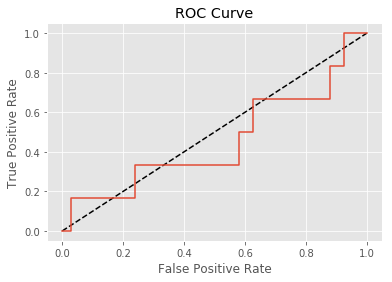

Results for LTCBTC
Confusion Matrix:
[[61  4]
 [ 8  0]]

             precision    recall  f1-score   support

      False       0.88      0.94      0.91        65
       True       0.00      0.00      0.00         8

avg / total       0.79      0.84      0.81        73



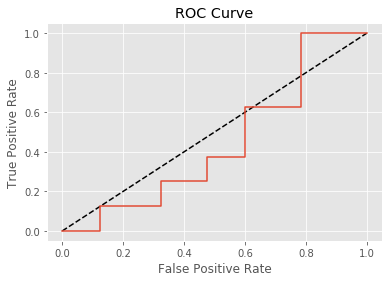

Results for BNBBTC
Confusion Matrix:
[[39 17]
 [12  5]]

             precision    recall  f1-score   support

      False       0.76      0.70      0.73        56
       True       0.23      0.29      0.26        17

avg / total       0.64      0.60      0.62        73



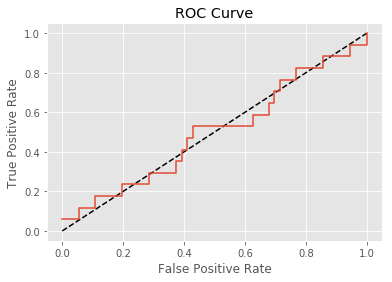

Results for NEOBTC
Confusion Matrix:
[[53  5]
 [14  1]]

             precision    recall  f1-score   support

      False       0.79      0.91      0.85        58
       True       0.17      0.07      0.10        15

avg / total       0.66      0.74      0.69        73



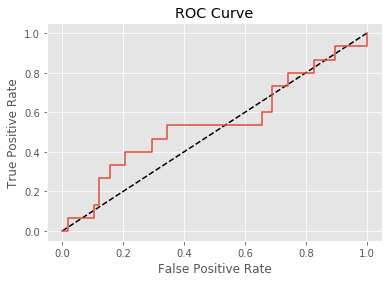

Results for BCCBTC
Confusion Matrix:
[[53  4]
 [13  3]]

             precision    recall  f1-score   support

      False       0.80      0.93      0.86        57
       True       0.43      0.19      0.26        16

avg / total       0.72      0.77      0.73        73



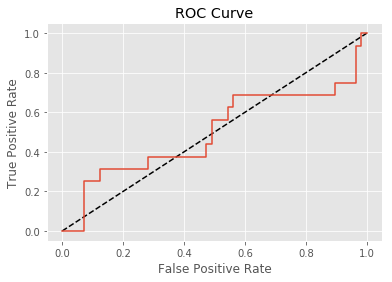

Results for GASBTC
Confusion Matrix:
[[25 20]
 [16 12]]

             precision    recall  f1-score   support

      False       0.61      0.56      0.58        45
       True       0.38      0.43      0.40        28

avg / total       0.52      0.51      0.51        73



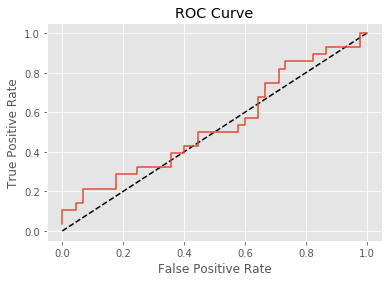

Results for HSRBTC
Confusion Matrix:
[[29 10]
 [13  6]]

             precision    recall  f1-score   support

      False       0.69      0.74      0.72        39
       True       0.38      0.32      0.34        19

avg / total       0.59      0.60      0.59        58



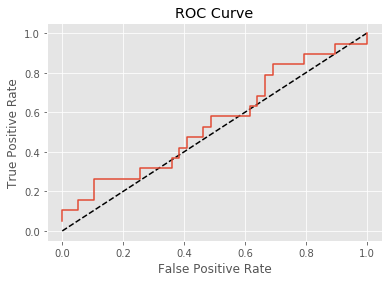

Results for MCOBTC
Confusion Matrix:
[[43  5]
 [19  4]]

             precision    recall  f1-score   support

      False       0.69      0.90      0.78        48
       True       0.44      0.17      0.25        23

avg / total       0.61      0.66      0.61        71



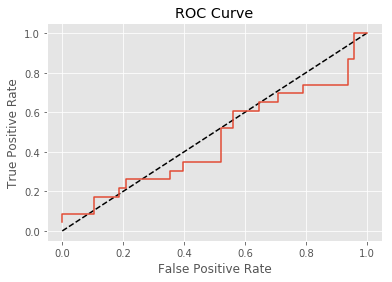

Results for WTCBTC
Confusion Matrix:
[[33 12]
 [15 10]]

             precision    recall  f1-score   support

      False       0.69      0.73      0.71        45
       True       0.45      0.40      0.43        25

avg / total       0.60      0.61      0.61        70



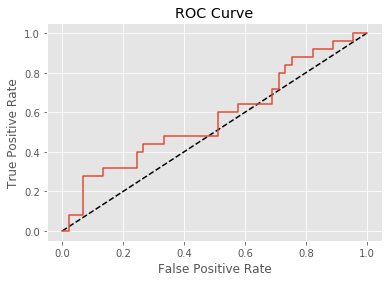

Results for LRCBTC
Confusion Matrix:
[[ 9 21]
 [13 11]]

             precision    recall  f1-score   support

      False       0.41      0.30      0.35        30
       True       0.34      0.46      0.39        24

avg / total       0.38      0.37      0.37        54



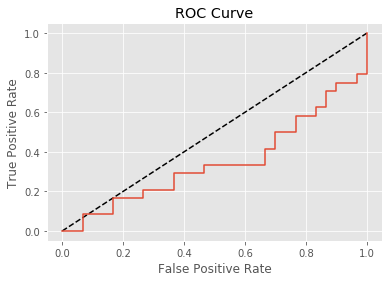

Results for QTUMBTC
Confusion Matrix:
[[47  7]
 [11  3]]

             precision    recall  f1-score   support

      False       0.81      0.87      0.84        54
       True       0.30      0.21      0.25        14

avg / total       0.71      0.74      0.72        68



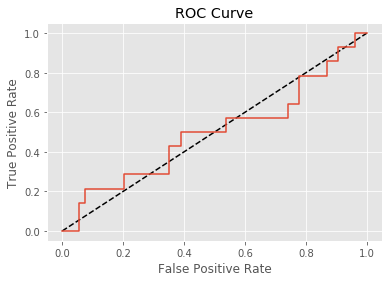

Results for YOYOBTC
Confusion Matrix:
[[14 13]
 [11 13]]

             precision    recall  f1-score   support

      False       0.56      0.52      0.54        27
       True       0.50      0.54      0.52        24

avg / total       0.53      0.53      0.53        51



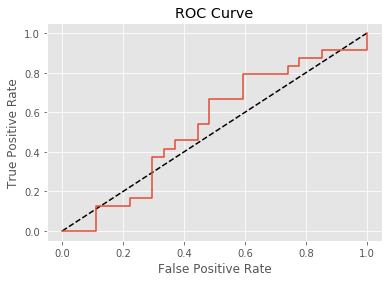

Results for OMGBTC
Confusion Matrix:
[[43  7]
 [11  5]]

             precision    recall  f1-score   support

      False       0.80      0.86      0.83        50
       True       0.42      0.31      0.36        16

avg / total       0.70      0.73      0.71        66



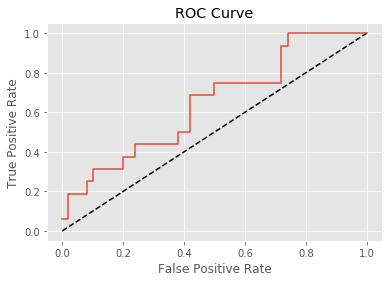

Results for ZRXBTC
Confusion Matrix:
[[36  6]
 [18  5]]

             precision    recall  f1-score   support

      False       0.67      0.86      0.75        42
       True       0.45      0.22      0.29        23

avg / total       0.59      0.63      0.59        65



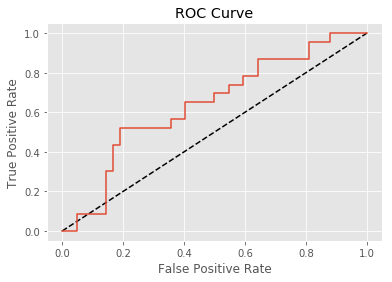

Results for STRATBTC
Confusion Matrix:
[[33 10]
 [18  4]]

             precision    recall  f1-score   support

      False       0.65      0.77      0.70        43
       True       0.29      0.18      0.22        22

avg / total       0.52      0.57      0.54        65



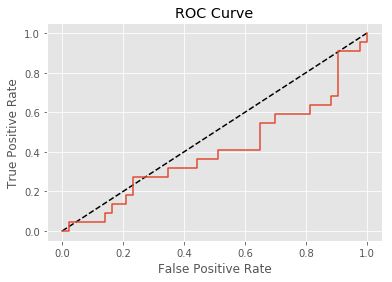

Results for SNGLSBTC
Confusion Matrix:
[[14 23]
 [12 14]]

             precision    recall  f1-score   support

      False       0.54      0.38      0.44        37
       True       0.38      0.54      0.44        26

avg / total       0.47      0.44      0.44        63



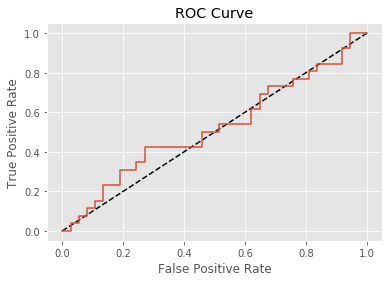

Results for BQXBTC
Confusion Matrix:
[[38  4]
 [ 9 12]]

             precision    recall  f1-score   support

      False       0.81      0.90      0.85        42
       True       0.75      0.57      0.65        21

avg / total       0.79      0.79      0.79        63



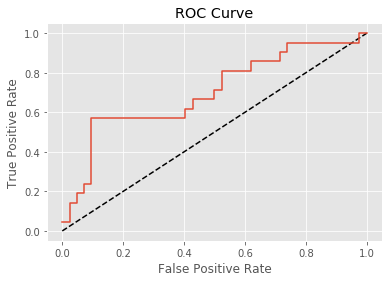

Results for KNCBTC
Confusion Matrix:
[[28 13]
 [ 9 11]]

             precision    recall  f1-score   support

      False       0.76      0.68      0.72        41
       True       0.46      0.55      0.50        20

avg / total       0.66      0.64      0.65        61



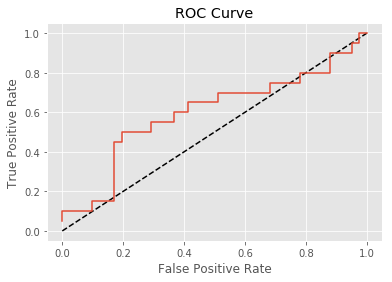

Results for FUNBTC
Confusion Matrix:
[[27 12]
 [15  7]]

             precision    recall  f1-score   support

      False       0.64      0.69      0.67        39
       True       0.37      0.32      0.34        22

avg / total       0.54      0.56      0.55        61



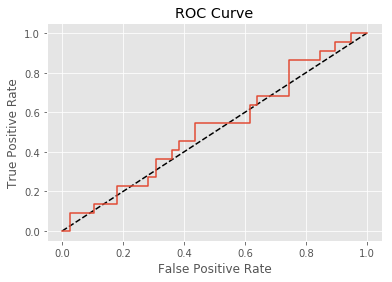

Results for SNMBTC
Confusion Matrix:
[[28 11]
 [15  7]]

             precision    recall  f1-score   support

      False       0.65      0.72      0.68        39
       True       0.39      0.32      0.35        22

avg / total       0.56      0.57      0.56        61



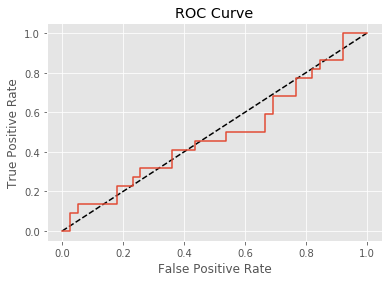

In [76]:
get_all_model(btc_1day_dict, 5, 'logreg', True)

<h3>Step 3.10 - Concat Data Frames </h3>

<p> </p>

can we dig deeper into the data to see which instances are true positives and which ones aren't? maybe we can find visual patterns that we aren't seeing from the numbers.

In [77]:
# def concat_all_pump_and_dump(df_dict, percentage = 0):
#     '''find all instances of PnD and returns a single df'''
  
#     #concatonate all dataframes inside given dictionary
#     temp_df = pd.concat(df_dict.values())
   
#     #find pump and dumps above the given percentage
#     temp_df = add_pnd_column(temp_df, percentage)
    
#     #assign dtypes, reset index
#     temp_df = clean_df_labels(temp_df)
    
#     #set index and sort by ticker and Open time
#     temp_df = temp_df.set_index(['ticker', 'Open time'])
#     temp_df.sort_index()
    
#     return temp_df

In [78]:
#is it possible to reverse engineer into a algorithm? starting with the quesstion is crypto movement random? if not, whats 
#not random? can we isolate the non randomness and create a model off of it?


<h3>Future Work</h3>

<p>
    automated bot, 
    pull realtime data to get current sell/buy orders,
    moving average analysis,
</p>